In [10]:
# %load_ext autoreload
# %autoreload 2
%matplotlib inline
import time
import math
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.insert(0, '../mppi_numba')
from mppi_numba.density import Density, GaussianMixture
from mppi_numba.terrain import Terrain, TDM_Numba, TractionGrid
from mppi_numba.visualization import TDM_Visualizer, vis_density, vis_density_as_pmf
from mppi_numba.mppi import MPPI_Numba
from mppi_numba.config import Config

In [11]:

# logfile = "mppi_benchmark/exp_log_20220823-1500.pickle" # 20 envs, 3 trials, 4 densities, 5 alphas
# logfile = "mppi_benchmark/exp_log_20220823-2327_margin_2_env_3_numtrial40.pickle"

# # logfile = "mppi_benchmark/exp_log_20220823-1853.pickle" # 30 envs, 5 trials, 3 densities, 5 alphas
# logfile = "mppi_benchmark/exp_log_20220824-0155_margin_1_env_10_numtrial10.pickle"

logfile = "mppi_benchmark/exp_log_20220828-1731_margin_1_env_10_numtrial5.pickle" # v_post_rollout=0.01, alpha doesn't do much



with open(logfile, 'rb') as fh:
  exp_log = pickle.load(fh)

for k, v in exp_log.items():
  if k not in ["logger", "default_mppi_params"]:
  # if k not in ["logger"]:
    print("{}: {}".format(k, v))

logger = exp_log['logger']
cfg = exp_log['cfg']
max_speed=exp_log['max_speed']
max_steps=exp_log['max_steps']
grid_shape=exp_log['grid_shape']
mud_margin=exp_log['mud_margin']
res=exp_log['res']
num_pmf_bins=exp_log['num_pmf_bins']
bin_values=exp_log['bin_values']
bin_values_bounds=exp_log['bin_values_bounds']
default_mppi_params=exp_log['default_mppi_params']
grass_density_list=exp_log['grass_density_list']
envs_per_density=exp_log['envs_per_density']
trials_per_env=exp_log['trials_per_env']
alpha_list=exp_log['alpha_list']
method_list=exp_log['method_list']
pmf_bounds=exp_log['pmf_bounds']
bush_weights=exp_log['bush_weights']
bush_means=exp_log['bush_means']
bush_std=exp_log['bush_std']
dirt_weights=exp_log['dirt_weights']
dirt_means=exp_log['dirt_means']
dirt_std=exp_log['dirt_std']

cfg: <mppi_numba.config.Config object at 0x7f6f1b601be0>
max_speed: 3.0
max_steps: 150
grid_shape: (9, 9)
mud_margin: 1
res: 1.0
num_pmf_bins: 22
bin_values: [0.    0.025 0.075 0.125 0.175 0.225 0.275 0.325 0.375 0.425 0.475 0.525
 0.575 0.625 0.675 0.725 0.775 0.825 0.875 0.925 0.975 1.   ]
bin_values_bounds: (0.0, 1.0)
grass_density_list: [0.2, 0.5, 0.8]
envs_per_density: 10
trials_per_env: 5
alpha_list: [1.0, 0.8, 0.6, 0.4, 0.2]
method_list: ['noisy_dyn', 'risk_dyn', 'nom_dyn_risk_cost']
pmf_bounds: [0, 1.0]
bush_weights: [0.6, 0.4]
bush_means: [0, 0.8]
bush_std: [0.15, 0.1]
dirt_weights: [1]
dirt_means: [0.65]
dirt_std: [0.1]


Terrain Vegetation has the following properties for linear and angular tractions.
mean=(0.51, 0.50), std=(0.35, 0.35), cvar(0.30)=(0.07, 0.07) (computed from 10000.0 saved samples)
Terrain Dirt has the following properties for linear and angular tractions.
mean=(0.65, 0.65), std=(0.10, 0.10), cvar(0.30)=(0.54, 0.53) (computed from 10000.0 saved samples)


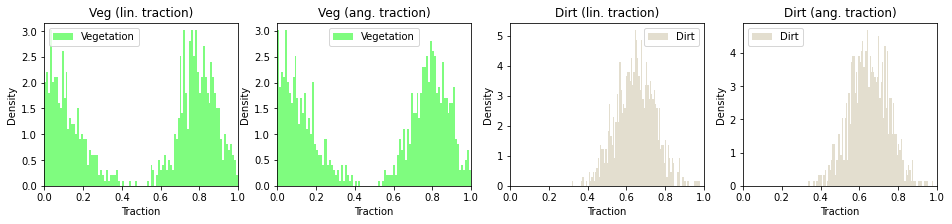

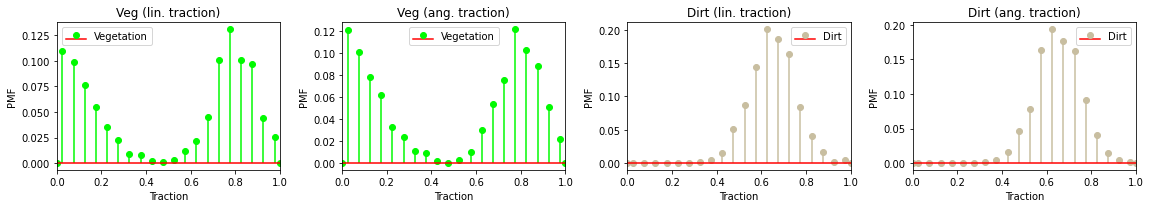

In [12]:
# What percentile of the speed distribution to compute conditional expectation?
cvar_alpha =0.3
bush_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
bush_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=bush_weights, means=bush_means, stds=bush_std)
dirt_lin_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)
dirt_ang_gm = GaussianMixture(sample_bounds=pmf_bounds, pmf_bounds=pmf_bounds, weights=dirt_weights, means=dirt_means, stds=dirt_std)

bush = Terrain(name='Vegetation', lin_density=bush_lin_gm, ang_density=bush_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((0,250,0))/255.0)
dirt = Terrain(name='Dirt', lin_density=dirt_lin_gm, ang_density=dirt_ang_gm, cvar_alpha=cvar_alpha, rgb=np.array((200,190,160))/255.0)
print(bush)
print(dirt)

ID2NAME = {
    0: dirt.name,
    1: bush.name
}
NAME2TERRAIN = {
    bush.name: bush,
    dirt.name: dirt
}

num_bins=20
b_lin_values, b_lin_pmf = bush_lin_gm.get_pmf(num_bins=num_bins)
b_ang_values, b_ang_pmf = bush_ang_gm.get_pmf(num_bins=num_bins)
d_lin_values, d_lin_pmf = dirt_lin_gm.get_pmf(num_bins=num_bins)
d_ang_values, d_ang_pmf = dirt_ang_gm.get_pmf(num_bins=num_bins)
LIN_TERRAIN2PMG = {
    bush: (b_lin_values, b_lin_pmf),
    dirt: (d_lin_values, d_lin_pmf),
}
ANG_TERRAIN2PMG = {
    bush: (b_ang_values, b_ang_pmf),
    dirt: (d_ang_values, d_ang_pmf),
}
# -------------- Visualize the speed distribution for each class---------
fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density(axes[0], bush_lin_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (lin. traction)", color=bush.rgb)
vis_density(axes[1], bush_ang_gm, bush, vis_cvar_alpha=cvar_alpha, title="Veg (ang. traction)", color=bush.rgb)
vis_density(axes[2], dirt_lin_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density(axes[3], dirt_ang_gm, dirt, vis_cvar_alpha=cvar_alpha, title="Dirt (ang. traction)", color=dirt.rgb)

fig, axes = plt.subplots(1, 4, figsize=(16, 3))
vis_density_as_pmf(axes[0], bush_lin_gm, bush, num_bins=num_bins, title="Veg (lin. traction)", color=bush.rgb)
vis_density_as_pmf(axes[1], bush_ang_gm, bush, num_bins=num_bins, title="Veg (ang. traction)", color=bush.rgb)
vis_density_as_pmf(axes[2], dirt_lin_gm, dirt, num_bins=num_bins, title="Dirt (lin. traction)", color=dirt.rgb)
vis_density_as_pmf(axes[3], dirt_ang_gm, dirt, num_bins=num_bins, title="Dirt (ang. traction)", color=dirt.rgb)

plt.tight_layout()
plt.show()

,time_to_goal,success,grass_density,grass_density_index,sem_map_index,method,alpha,map_sample_index
0,13.2,True,0.2,0,0,noisy_dyn,1.0,0
1,13.8,True,0.2,0,0,noisy_dyn,1.0,1
2,11.7,True,0.2,0,0,noisy_dyn,1.0,2
3,11.0,True,0.2,0,0,noisy_dyn,1.0,3
4,13.2,True,0.2,0,0,noisy_dyn,1.0,4
...,...,...,...,...,...,...,...,...
2245,NaN,False,0.8,2,9,nom_dyn_risk_cost,0.2,0
2246,NaN,False,0.8,2,9,nom_dyn_risk_cost,0.2,1
2247,NaN,False,0.8,2,9,nom_dyn_risk_cost,0.2,2
2248,NaN,False,0.8,2,9,nom_dyn_risk_cost,0.2,3


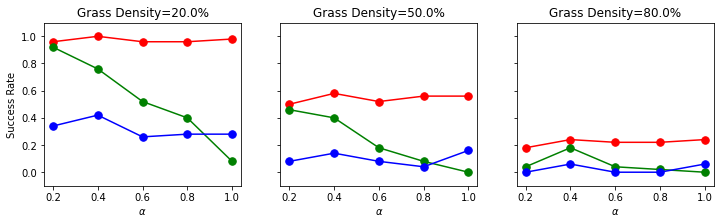

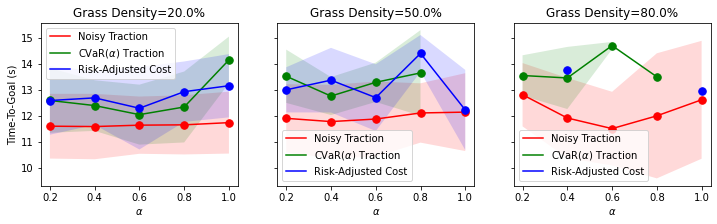

In [13]:
display(logger)

method2rgb = {
  'noisy_dyn': 'r',
  'risk_dyn': 'g',
  'nom_dyn_risk_cost': 'b'
}
method2label = {
  'noisy_dyn': 'Noisy Traction',
  'risk_dyn': r'CVaR($\alpha$) Traction',
  'nom_dyn_risk_cost': 'Risk-Adjusted Cost'
}
figsize=(12, 3)
sorted_grass_density_list = sorted(grass_density_list)
sorted_alpha_list = sorted(alpha_list)
# Plot success rate vs. alpha for each method
fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)
for density_i, grass_density in enumerate(sorted_grass_density_list):
  ax = axes[density_i]
  for method in method_list:
    success_rate = []
    for alpha in sorted_alpha_list:
      sub_logger = logger[(logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      success_rate.append(sub_logger['success'].sum()/len(sub_logger))
    success_rate = np.asarray(success_rate)
    ax.plot(sorted_alpha_list, success_rate, '-', color=method2rgb[method], label=method2label[method])
    ax.plot(sorted_alpha_list, success_rate, '.', color=method2rgb[method], markersize=15)
  # ax.legend()
  ax.set_ylim([-0.1,1.1])
  if density_i==0:
    ax.set_ylabel('Success Rate')
  ax.set_xlabel(r'$\alpha$')
  ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

# Plot time-to-goal for successful trials for each alpha
fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=figsize)
for density_i, grass_density in enumerate(sorted_grass_density_list):
  ax = axes[density_i]
  for method in method_list:
    t2g = []
    t2g_std = []
    for alpha in sorted_alpha_list:
      sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      if len(sub_logger)>0:
        t2g.append(sub_logger['time_to_goal'].sum()/len(sub_logger))
        t2g_std.append(sub_logger['time_to_goal'].std())
      else:
        t2g.append(np.nan)
        t2g_std.append(np.nan)

        
    t2g = np.asarray(t2g)
    t2g_std = np.asarray(t2g_std)
    ax.plot(sorted_alpha_list, t2g, '-', color=method2rgb[method], label=method2label[method])
    ax.fill_between(sorted_alpha_list, t2g-t2g_std, t2g+t2g_std,
              alpha=0.15, edgecolor='none', facecolor=method2rgb[method])
    ax.plot(sorted_alpha_list, t2g, '.', color=method2rgb[method], markersize=15)
  ax.legend()
  if density_i==0:
    ax.set_ylabel('Time-To-Goal (s)')
  ax.set_xlabel(r'$\alpha$')
  ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

### What happened when alpha is small and our proposed method does worse than CVaR(alpha) dynamics? It's likely that the CVaR dynamics planner just assumes all grass patches are not traversable, thus moving around all the grass patches.

* Try the distribution in IROS paper
* Reduce mean of the dirt to be 0.6 instead of 0.8
* Reduce the time-to-go cost?
* Flatten the bimodal distribution of the grass more
* If time permits, increase the number of env samples ? (Maybe difficult in short time)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


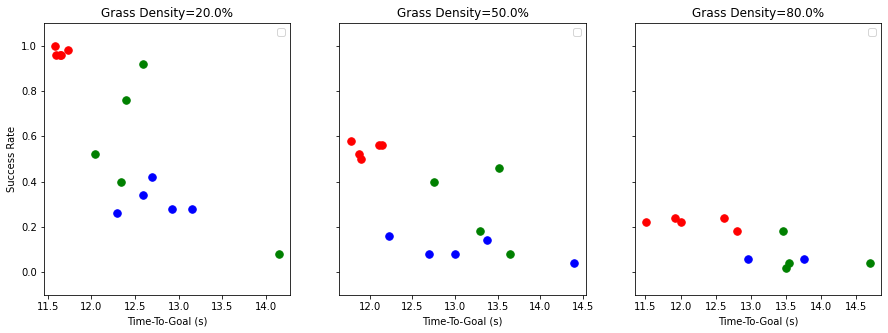

In [14]:
# Visualize the trade-off plots?
# Plot success rate vs. alpha for each method
fig, axes = plt.subplots(ncols=len(sorted_grass_density_list), sharey=True, figsize=(15, 5))
for density_i, grass_density in enumerate(sorted_grass_density_list):
  ax = axes[density_i]
  for method in method_list:
    success_rate = []
    t2g = []
    for alpha in sorted_alpha_list:
      sub_logger = logger[(logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      success_rate.append(sub_logger['success'].sum()/len(sub_logger))

      sub_logger = logger[logger['success'] & (logger['grass_density']==grass_density) & (logger['method']==method) & (logger['alpha']==alpha)]
      if len(sub_logger)>0:
        t2g.append(sub_logger['time_to_goal'].sum()/len(sub_logger))
        # t2g_std.append(sub_logger['time_to_goal'].std())
      else:
        t2g.append(np.nan)
        # t2g_std.append(np.nan)
    success_rate = np.asarray(success_rate)
    # ax.plot(t2g, success_rate, '-', color=method2rgb[method], label=method2label[method])
    ax.plot(t2g, success_rate, '.', color=method2rgb[method], markersize=15)
  ax.legend()
  ax.set_ylim([-0.1,1.1])
  if density_i==0:
    ax.set_ylabel('Success Rate')
  ax.set_xlabel('Time-To-Goal (s)')
  ax.set_title('Grass Density={:.1f}%'.format(grass_density*100))

In [17]:
# Visualization the time-to-goal using boxplots instead
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

def make_boxplot(data, tick_labels, alg_names, colors, group_length=2, space_between_group = 0.3, 
                 space_between_box = 0.1, xlabel=None, ylabel=None, title=None,
                alg2legends=None, ax=None, show_legend=True, fontsize=10):
    

    
    tick_group_width = group_length - space_between_group
    width = (tick_group_width - space_between_box*(len(alg_names)-1)) / (len(alg_names))
    
    
    if not ax:
        fig, ax = plt.subplots()
        
    for idx, alg in enumerate(alg_names):
        offset = -tick_group_width/2. + (width+space_between_box)*(idx+0.5)
        bp = ax.boxplot(data[alg], positions=np.array(range(len(tick_labels)))*group_length+offset, 
                         sym='', widths=width)
        # bp = ax.boxplot(data[alg], positions=np.array(range(len(tick_labels)))*group_length+offset, widths=width)
        set_box_color(bp, colors[alg]) 

        # draw temporary red and blue lines and use them to create a legend
        if alg2legends:
            ax.plot([], c=colors[alg], label=alg2legends[alg])
        else:
            ax.plot([], c=colors[alg], label=alg)
        plt.legend()
    plt.xticks(range(0, len(tick_labels) * group_length, group_length), tick_labels)
    plt.xlim(-0.5*group_length, len(tick_labels)*group_length - 0.5*group_length)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=fontsize)
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=fontsize)
    if title:
        ax.set_title(title, fontsize=fontsize)
#     plt.tight_layout()
    
    return ax

def get_boxplot_logger(df, column_name, grass_density, algs, alpha_list, scale=1.0):
    logger = dict()
    grass_density_mask = df['grass_density']==grass_density
    success_mask = df['success']
    for alg in algs:
        logger[alg] = []
        alg_mask = df["method"]==alg
        for alpha_idx, alpha in enumerate(alpha_list):
            alpha_mask = df["alpha"]==alpha
            logger[alg].append(df[success_mask&alpha_mask&alg_mask&grass_density_mask][column_name].to_numpy()*scale)
    return logger

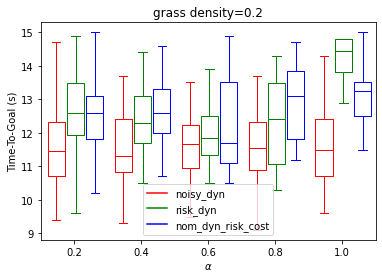

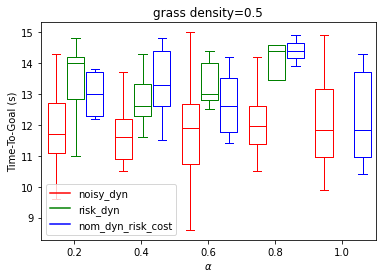

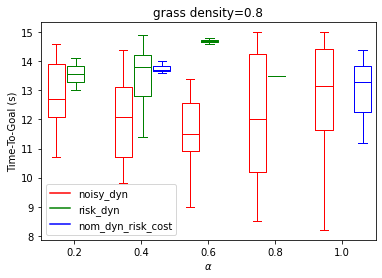

In [18]:
column_name = 'time_to_goal'
for grass_density in sorted_grass_density_list:
  boxplot_logger = get_boxplot_logger(logger, column_name, grass_density, method_list, sorted_alpha_list)
  xticks = sorted_alpha_list
  fig, ax = plt.subplots()
  ax = make_boxplot(boxplot_logger, xticks, method_list, method2rgb,
                        group_length = 3, space_between_group = 0.5,
                        space_between_box = 0.1,
                        title='',
                        xlabel=r"$\alpha$",
                        ylabel="Time-To-Goal (s)",
                        ax=ax)
  ax.set_title("grass density={}".format(grass_density))